Run this after example_meteoradar

In [1]:
import numpy as np
import uuid
import tiledb
import requests

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from tdmq.client.client import Client

INFO:tdmq.db:Logging is active.


In [4]:
# tdmq constants
TDMQ_BASE_URL = 'http://web:8000/api/v0.0'
TILEDB_HDFS_ROOT = 'hdfs://hdfs:9000/arrays'
TDMQ_NAMESPACE_UUID = uuid.UUID('367b5aee-8609-3c20-b130-4eb927a2d62b')
TILEDB_CTX = tiledb.Ctx({'vfs.hdfs.username': 'root'})

In [5]:
c = Client(TDMQ_BASE_URL, TILEDB_CTX)

In [6]:
# FIXME adding missing sensor_class
from tdmq.client.client import sensor_classes
sensor_classes['temperatureSensorNetwork'] = sensor_classes['meteoRadar']
sensor_classes

{'meteoRadar': tdmq.client.sensors.NonScalarSensor,
 'temperatureSensorNetwork': tdmq.client.sensors.NonScalarSensor}

In [9]:
args = {
    'footprint': 'circle((9.2215, 30.0015), 1000000)',
    'after': '2019-06-22T00:00:00Z',
    'before':'2019-06-23T21:50:25Z',
}
sensors = c.get_sensors(args)
sensors

In [11]:
sensors[1].description

{'code': '8d59a41d-a1ea-5a54-bf72-80273171530c',
 'controlledProperty': ['TEMP'],
 'geometry': {'coordinates': [[[6.0, 47.50026321411133, 0.0, 1.0],
    [6.0, 35.990049599775915, 0.0, 1.0],
    [18.60927915042647, 35.990049599775915, 0.0, 1.0],
    [18.60927915042647, 47.50026321411133, 0.0, 1.0],
    [6.0, 47.50026321411133, 0.0, 1.0]]],
  'type': 'Polygon'},
 'geotiff_tags': {'GTModelTypeGeoKey': 2,
  'GTRasterTypeGeoKey': 1,
  'GeographicTypeGeoKey': 4326,
  'KeyDirectoryVersion': 1,
  'KeyRevision': 1,
  'KeyRevisionMinor': 2,
  'ModelTransformation': [[0.019983009747110096, 0.0, 0.0, 6.0],
   [0.0, -0.019983009747110096, 0.0, 47.50026321411133],
   [0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]]},
 'grid': {'xsize': 631, 'ysize': 576},
 'name': 'dpc_temperature_mosaic',
 'node': 'dpi',
 'timebase': '2019-06-22T22:00:00Z',
 'timedelta': 3600.0,
 'type': 'Mosaic_of_dpc_temperature_sensors'}

In [12]:
args = {
    'after': '2019-06-22T10:00:00Z',
    'before':'2019-06-23T21:50:25Z',
}
ts = sensors[1].timeseries(**args)

In [13]:
(tdeltas, data) = ts[4]

In [14]:
temp = data['TEMP'] * (data['TEMP'] > -9000.0)

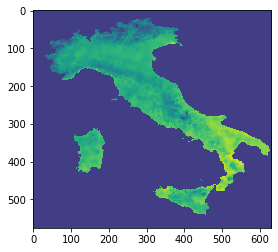

In [15]:
plt.imshow(temp)

In [16]:
(tdeltas, data) = ts[4, 300:440, 100:200]

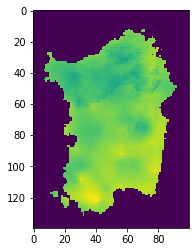

In [17]:
plt.imshow(data['TEMP'] * (data['TEMP'] > -9000.0))

In [18]:
(tdeltas, data) = ts[0:100, 300:440, 100:200]

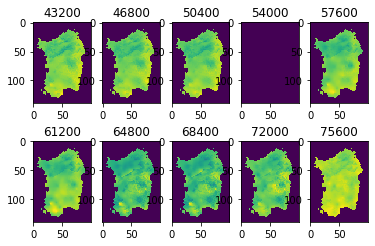

In [19]:
N = 10
temp = data['TEMP']
fig, axes = plt.subplots(N//5, 5)
for i in range(N):
    ax = axes[i//5, i%5]
    ax.imshow(temp[i]* (temp[i] > -9000.0))
    ax.set_title('%d' % tdeltas[i])